# Titanic: Machine Learning from Disaster

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

In [3]:
train_df = pd.read_csv('data/titanic/train.csv')
test_df = pd.read_csv('data/titanic/test.csv')

df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
df.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

In [8]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Text(0.5, 1, 'Missing values')

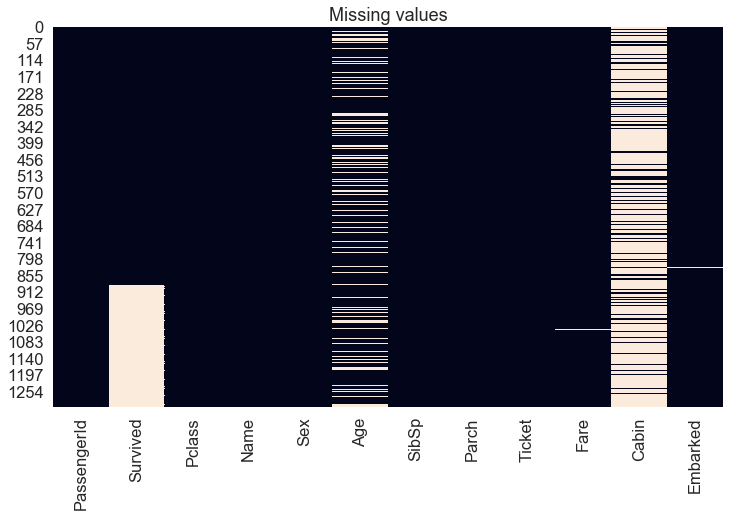

In [9]:
sns.heatmap(df.isnull(), cbar=False).set_title("Missing values")

Text(0.5, 1.0, 'Percentage of people survived and deceased')

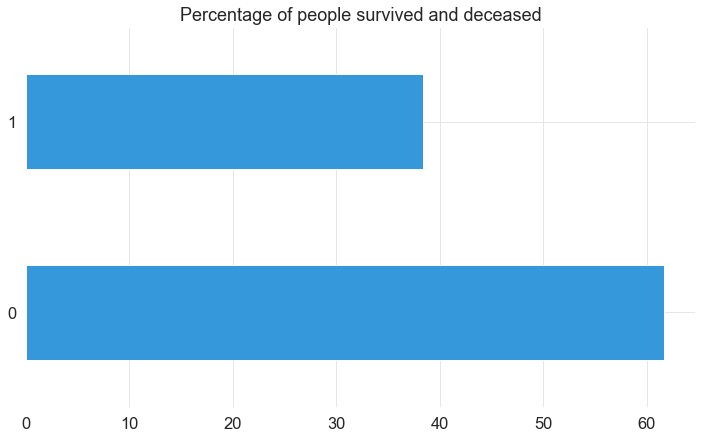

In [10]:
(train_df.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("Percentage of people survived and deceased")

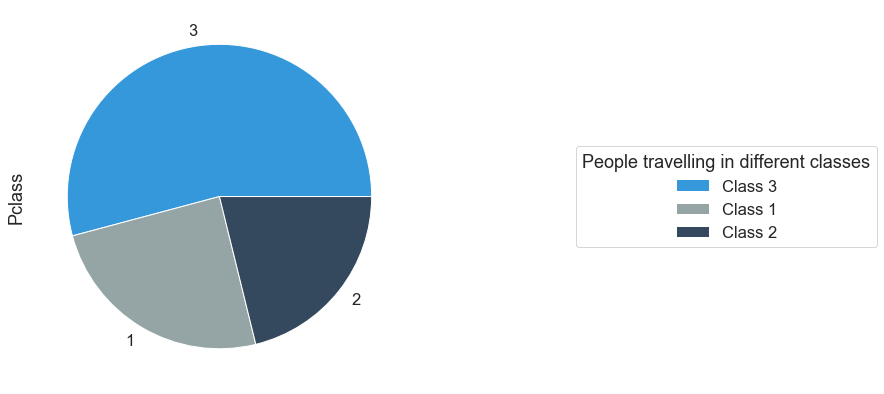

In [11]:
fig_pclass = df.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("People travelling in different classes")

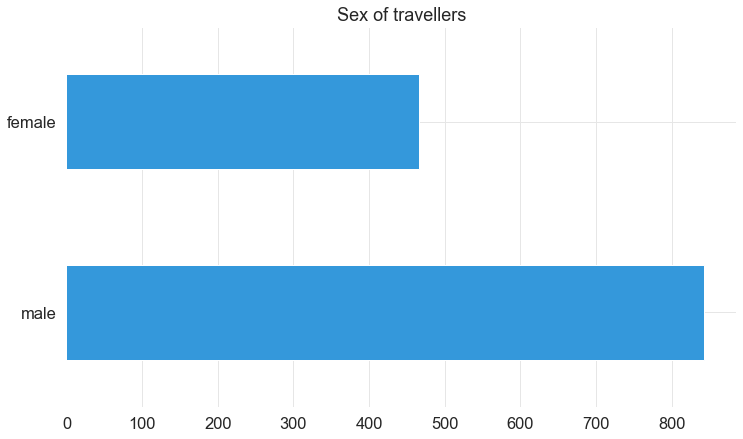

In [12]:
fig_sex = df.Sex.value_counts().plot.barh().set_title("Sex of travellers")

## Приступим к преобразованию и дозаполнению недостающих данных. Начнем с преобразования переменной пола к числовому (номинативному) виду:

In [13]:
df['Sex_Female'] = df.Sex.map({'male': 0, 'female': 1})

Text(0.5, 1, 'Correlation Map')

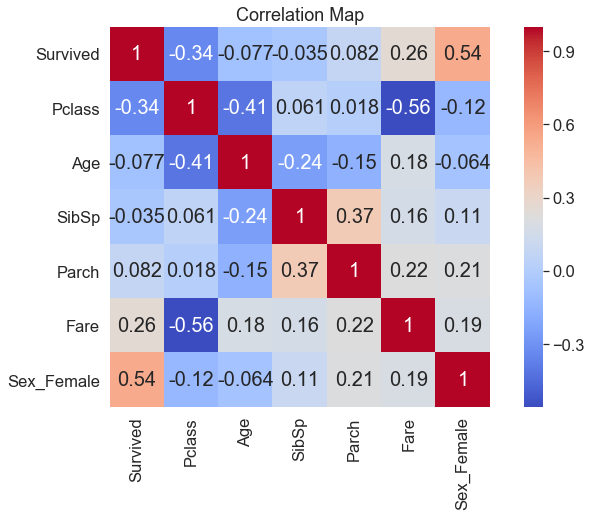

In [14]:
sns.heatmap(df.drop(['PassengerId'], axis=1).corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 20}).set_title('Correlation Map')

In [15]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Sex_Female        0
dtype: int64

## Посмотрим на пассажира, для которого неизвестен показатель Fare:

In [16]:
df[df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0


## Как мы видим, он путешествует один третьим классом, однако является человеком в возрасте, что может натолкнуть на мысль, что билет был приобретен по льготной стоимости для пенсионеров. Посмотрим на людей, которые находятся в похожих условиях:

In [17]:
df.query('Age > 60 & Pclass == 3 & SibSp + Parch == 0')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female
116,117,0.0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0
280,281,0.0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q,0
326,327,0.0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S,0
483,484,1.0,3,"Turkula, Mrs. (Hedwig)",female,63.0,0,0,4134,9.5875,NaN,S,1
851,852,0.0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,0
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0


## Возьмем их медианную стоимость билета и присвоим ее билету данного пассажира

In [18]:
df.Fare = df.Fare.fillna(df.query('Age > 60 & Pclass == 3 & SibSp + Parch == 0').Fare.median())

## Посмотрим на пассажиров, для которых неизвестны их порта отправления:

In [19]:
df[df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


## Посмотрим на общую картину по портам:

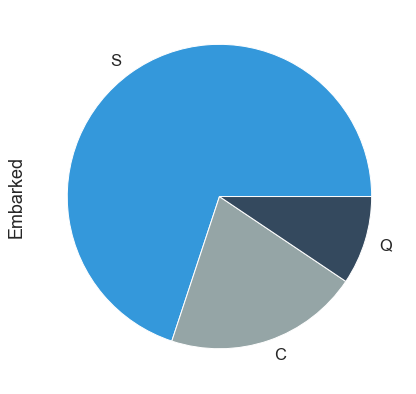

In [20]:
fig_sex = df.Embarked.value_counts().plot.pie()

## Как мы видим, большинство пассажиров отправлялось с порта S (Southampton), поэтому присвоим данным пассажирам отправление с данного порта:

In [21]:
df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

## Однако у нас все еще остается 263 пассажира, для которых совершенно неизвестен их возраст. Можно было бы подставить медианное значение возраста, но мне показалось это слишком грубой заменой, поэтому было принято решение сгрупировать данные по полу и классу и применить подстановку внутри каждой из групп:

In [22]:
grp = df.groupby(['Sex', 'Pclass'])  
df.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

## Теперь приступим к преобразованию переменной Cabin. Ее значение практически всегда уникально, поэтому имеет смысл как-то поколдовать над этой переменной. Первая буква в названии каюты - отсек, в котором она располагалась. Поэтому можно подвести ее к более опрятному виду:

<img src="files/images/Titanic_side_plan.png">

In [23]:
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

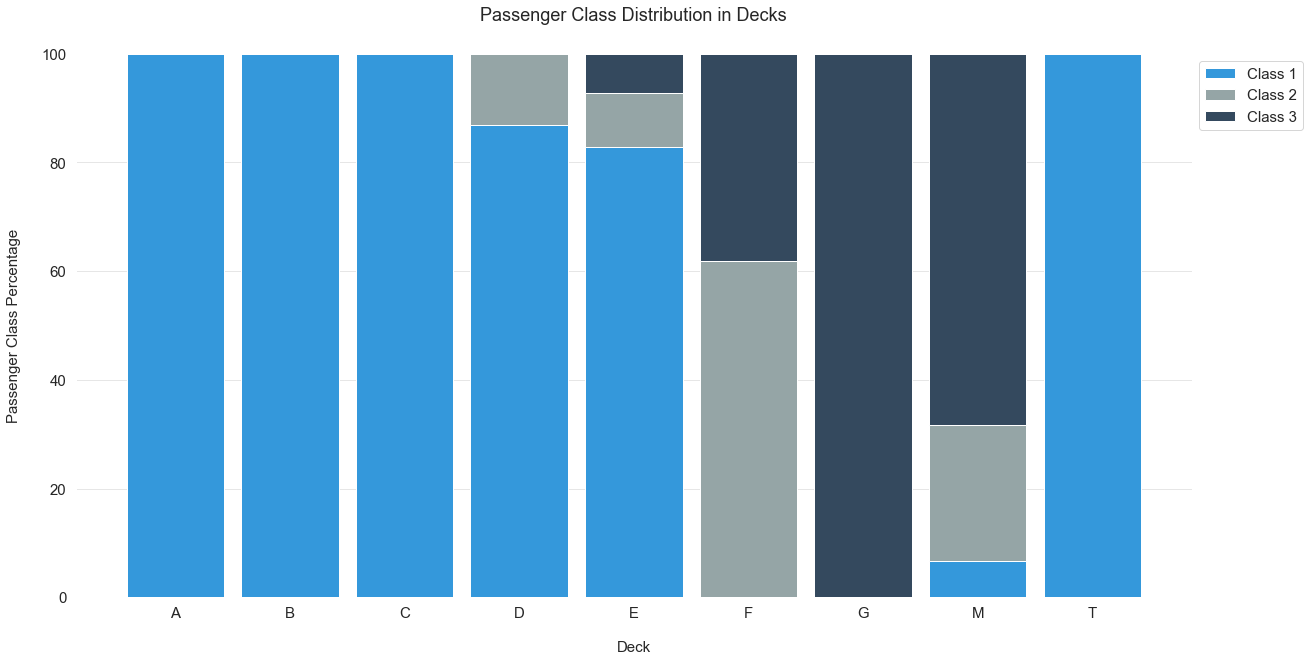

In [24]:
df_all_decks = df.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                    'Embarked', 'Cabin', 'PassengerId', 'Ticket']
                                                          ).rename(columns={'Name': 'Count'}).transpose()
def get_pclass_dist(df):
    
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
            except KeyError:
                deck_counts[deck][pclass] = 0
            else:
                deck_counts[deck][pclass] = count 
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages


def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85

    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, edgecolor='white', width=bar_width, label='Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, edgecolor='white', width=bar_width, label='Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, edgecolor='white', width=bar_width, label='Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   

    plt.show()  

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

## В отсеке T оказался только один пассажир, поэтому дабы избежать переобучения, "переместим" его в отсек A:

In [25]:
idx = df[df['Deck'] == 'T'].index
df.loc[idx, 'Deck'] = 'A'

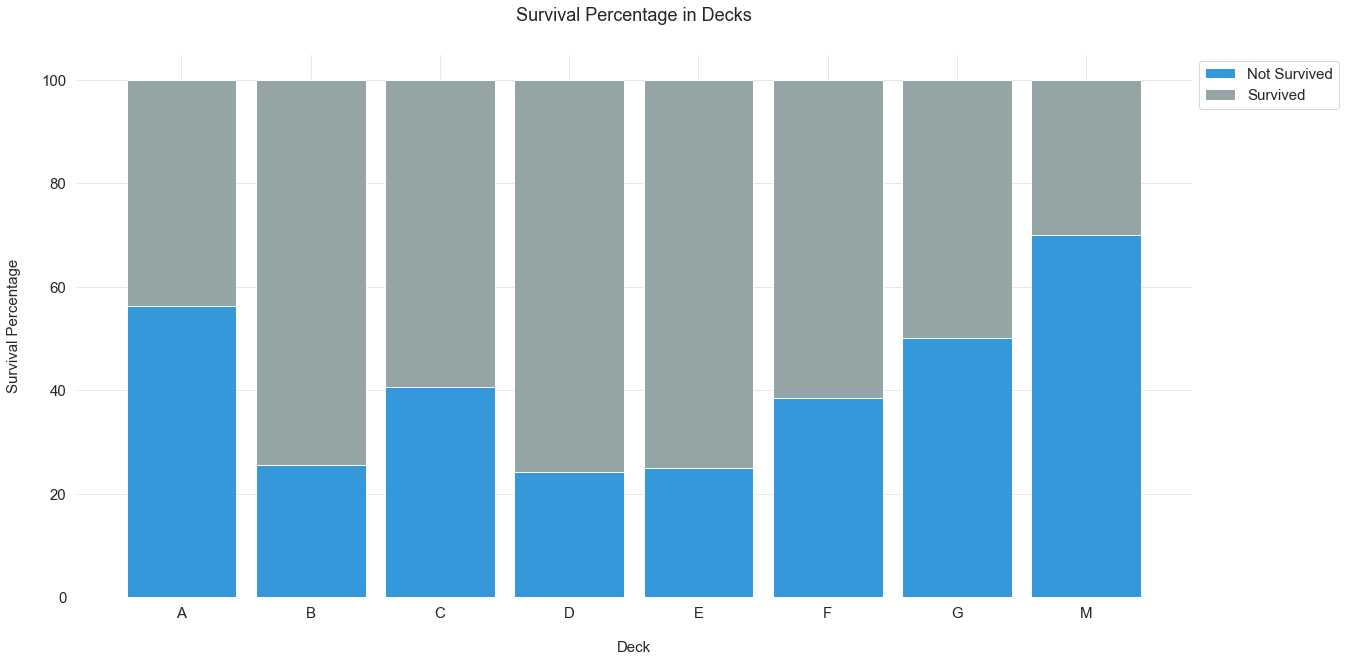

In [26]:
df_all_decks_survived = df.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                               'Embarked', 'Pclass', 'Cabin', 'PassengerId', 
                                                                               'Ticket']
                                                                     ).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

## Как мы видим, данное преобразование оказалось очень полезным, сгруппируем отсеки:

In [27]:
df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'ABC')
df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

df['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

## Взглянем на общую тенденцию по разным критериям:

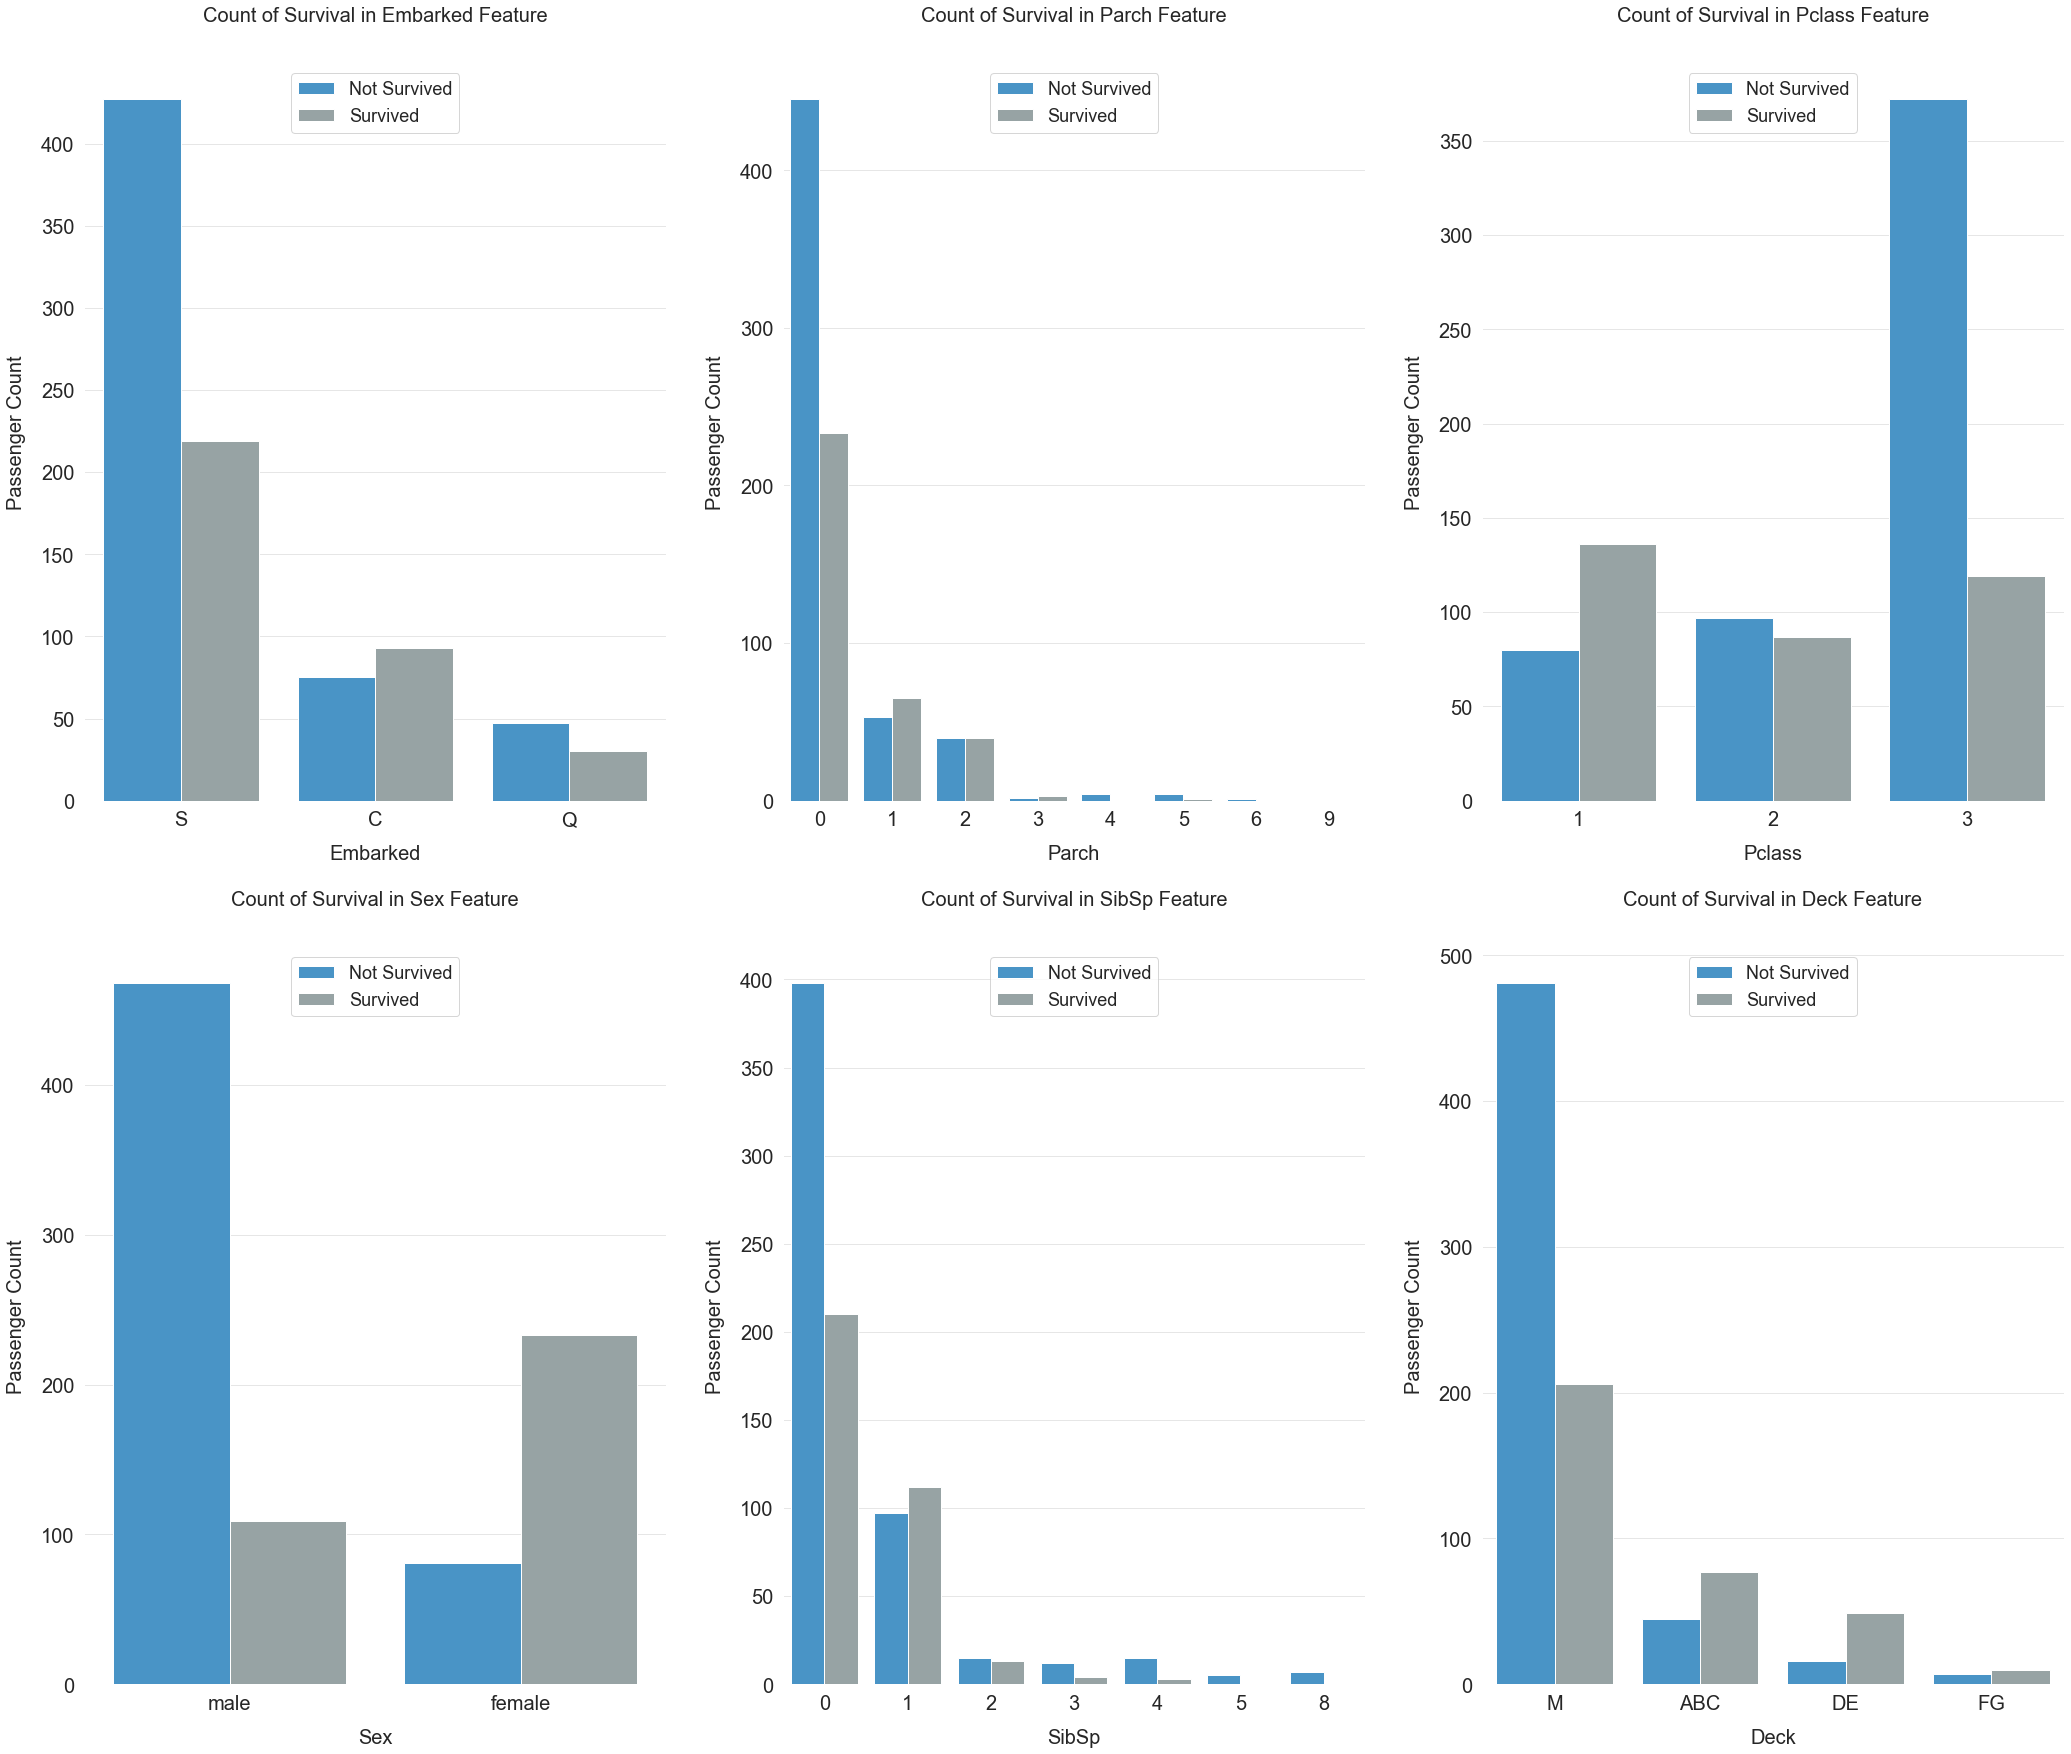

In [28]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title(f'Count of Survival in {feature} Feature', size=20, y=1.05)

plt.show()

## Сгруппируем значения цены билета:

In [29]:
df['Fare_Category'] = pd.cut(df['Fare'], bins=[0, 7.90, 14.45, 31.28, 120], labels=['Low', 'Mid', 'High_Mid', 'High'])

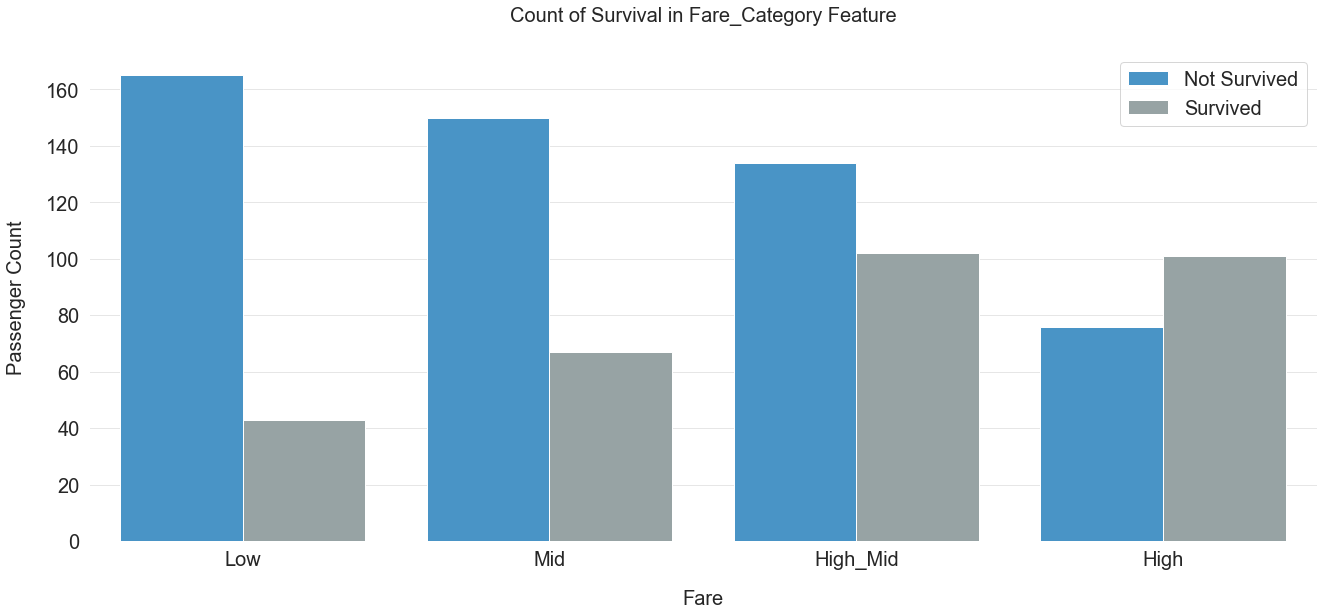

In [30]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare_Category', hue='Survived', data=df)

plt.xlabel('Fare', size=20, labelpad=20)
plt.ylabel('Passenger Count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
plt.title('Count of Survival in Fare_Category Feature', size=20, y=1.05)

plt.show()

## Сгруппируем значения возраста:

In [31]:
df['Age_Range'] = pd.qcut(df['Age'], 10)

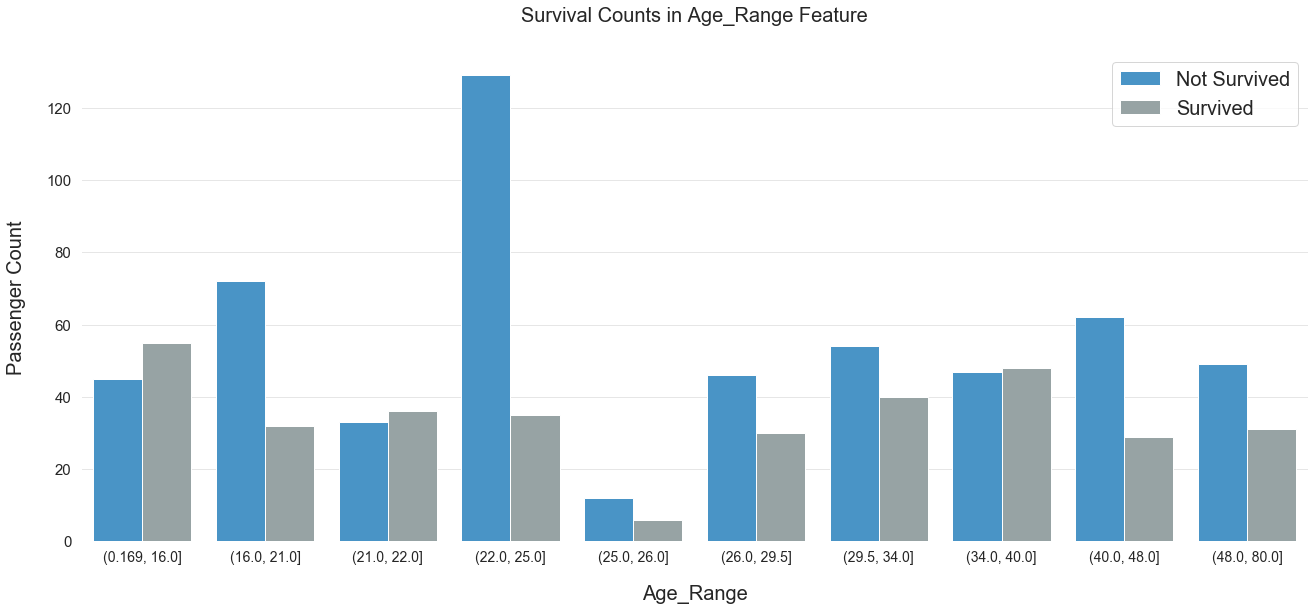

In [32]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age_Range', hue='Survived', data=df)

plt.xlabel('Age_Range', size=20, labelpad=20)
plt.ylabel('Passenger Count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
plt.title('Survival Counts in Age_Range Feature', size=20, y=1.05)

plt.show()

In [33]:
df['Age_Category'] = pd.cut(df['Age'], bins=[0, 16, 30, 40, 70], labels=['Child', 'Young', 'Adult', 'Elderly'])

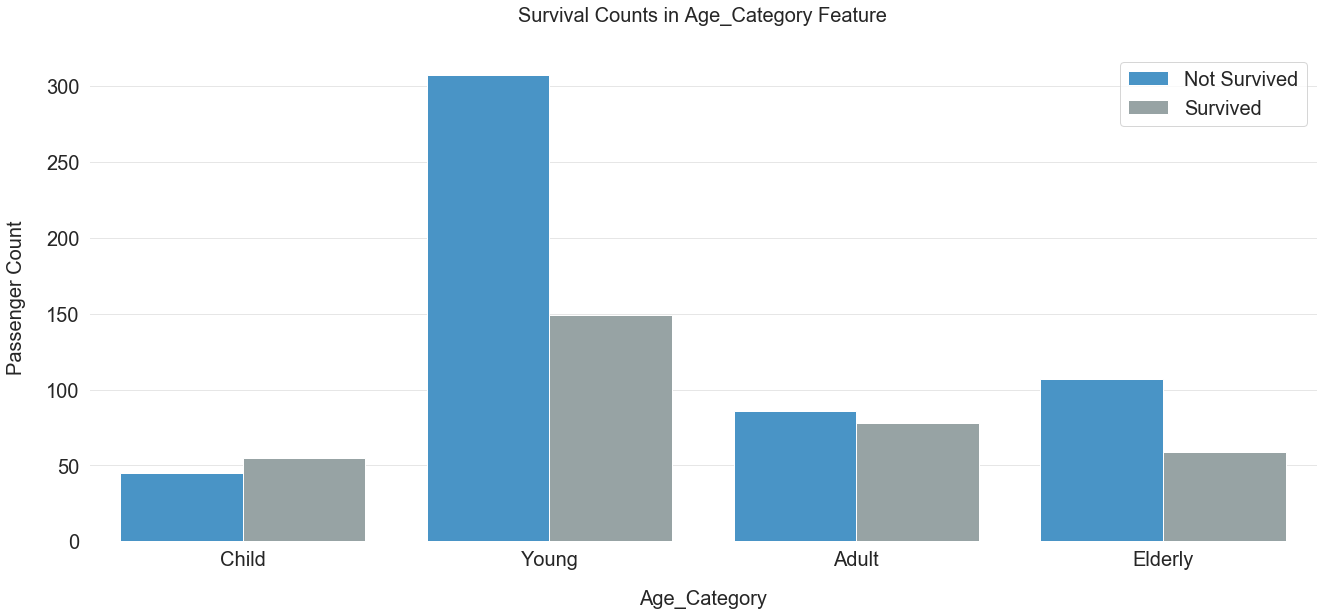

In [34]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age_Category', hue='Survived', data=df)

plt.xlabel('Age_Category', size=20, labelpad=20)
plt.ylabel('Passenger Count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
plt.title('Survival Counts in Age_Category Feature', size=20, y=1.05)

plt.show()

## Поработаем с параметрами Parch и SibSp. До этого мы затрагивали их, когда пытались прикинуть стоимость билета одинокого дедушки. Поскольку Parch - количество детей/родителей, а SibSp - количество братьев/сестер, мы можем посчитать количество членов семьи на борту для каждого пассажира:

In [35]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

In [36]:
df.groupby('Family_Size')['Name'].count()

Family_Size
1     790
2     235
3     159
4      43
5      22
6      25
7      16
8       8
11     11
Name: Name, dtype: int64

## Замапим полученные значения и преобразуем получившиеся значения

In [37]:
family_map = {
    1: 'Alone', 
    2: 'Small', 
    3: 'Small', 
    4: 'Small', 
    5: 'Medium', 
    6: 'Medium', 
    7: 'Large', 
    8: 'Large', 
    11: 'Large'
}
df['Family_Size_Grouped'] = df['Family_Size'].map(family_map)

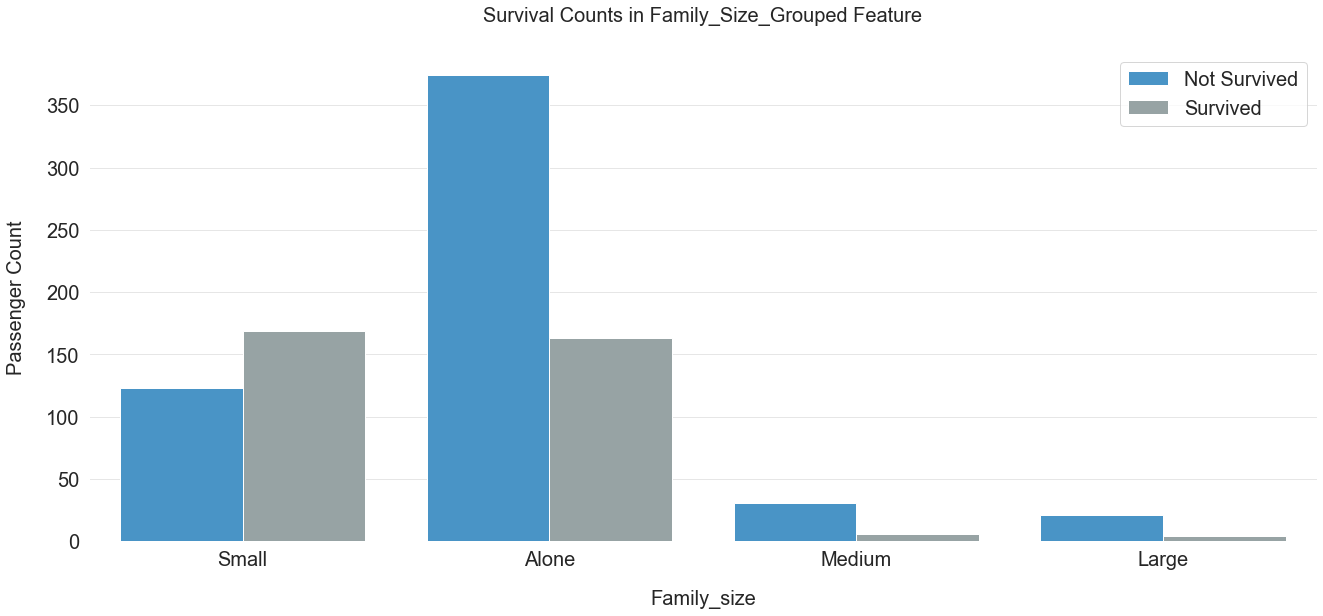

In [38]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df)

plt.xlabel('Family_size', size=20, labelpad=20)
plt.ylabel('Passenger Count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
plt.title('Survival Counts in Family_Size_Grouped Feature', size=20, y=1.05)

plt.show()

## Однако присмотревшись к фиче Ticket, можно заметить, что для некоторых пассажиров билеты совпадает, из чего означает, что некоторые пассажиры путешествовали группой, следовательно, можно сделать для них аналогичную группировку:

In [39]:
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')

In [40]:
df['Ticket_Frequency_Grouped'] = df['Ticket_Frequency'].map(family_map)

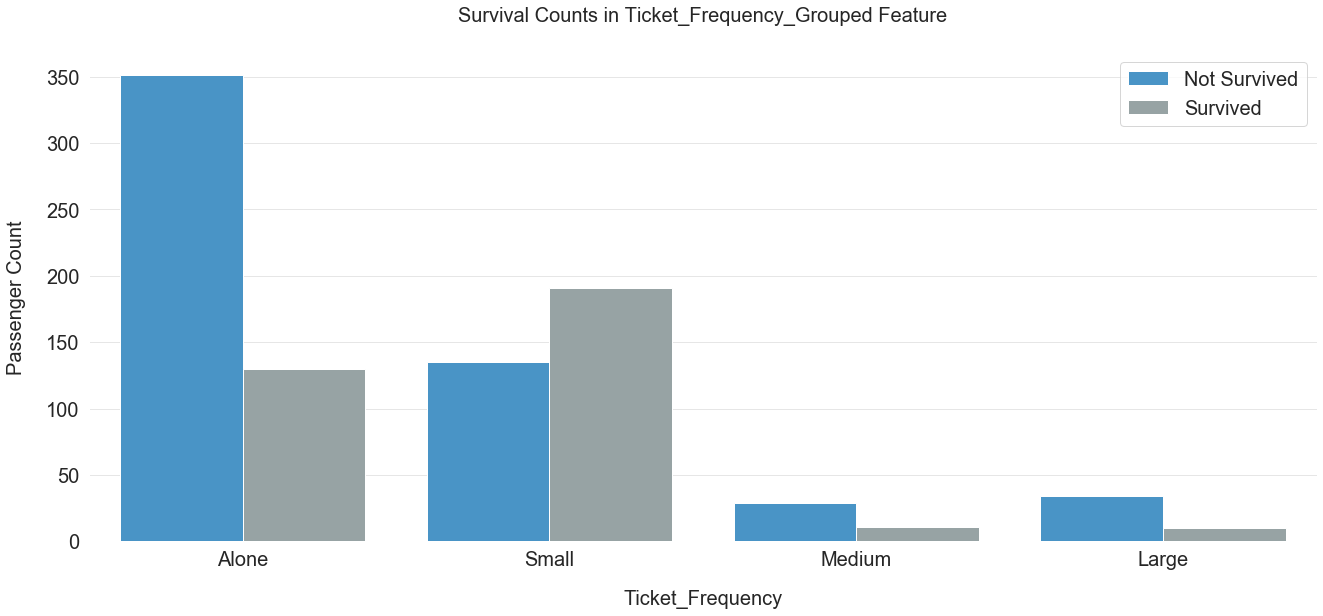

In [41]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Ticket_Frequency_Grouped', hue='Survived', data=df)

plt.xlabel('Ticket_Frequency', size=20, labelpad=20)
plt.ylabel('Passenger Count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
plt.title('Survival Counts in Ticket_Frequency_Grouped Feature', size=20, y=1.05)

plt.show()

In [42]:
df['Company_Size'] = df.apply(lambda x: x['Ticket_Frequency'] if x['Ticket_Frequency'] >= x['Family_Size'] else x['Family_Size'], axis=1)

In [43]:
df.groupby('Company_Size')['Name'].count()

Company_Size
1     663
2     263
3     186
4      71
5      37
6      25
7      37
8      16
11     11
Name: Name, dtype: int64

In [44]:
df['Company_Size_Grouped'] = df['Company_Size'].map(family_map)

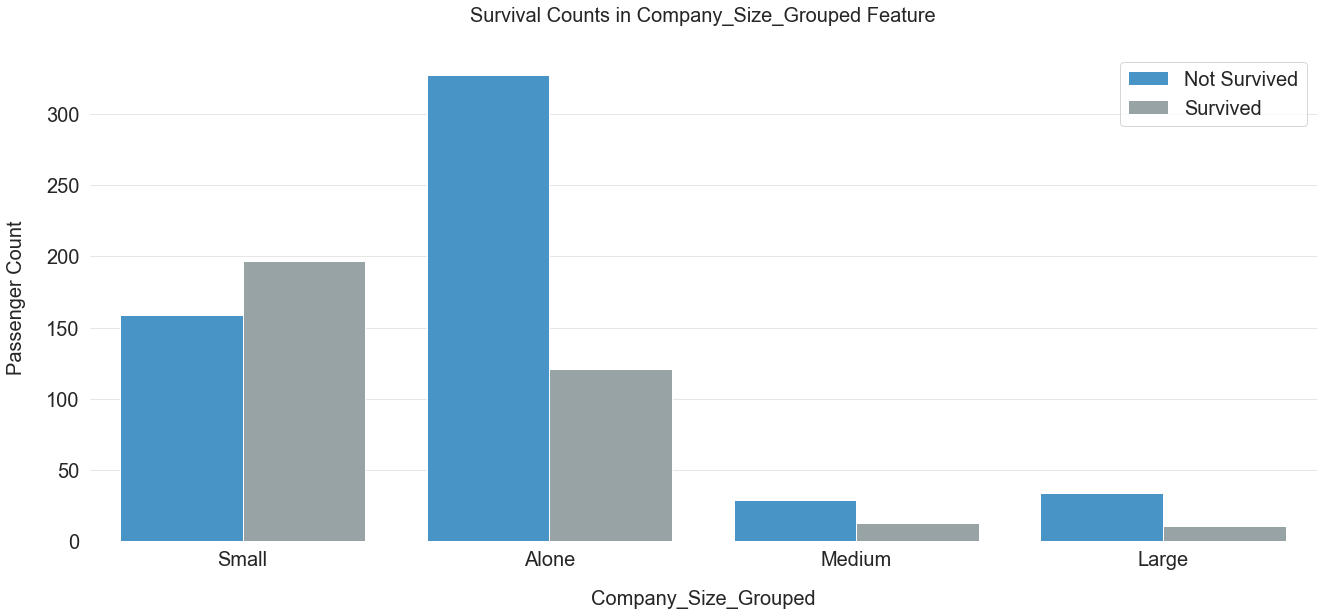

In [45]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Company_Size_Grouped', hue='Survived', data=df)

plt.xlabel('Company_Size_Grouped', size=20, labelpad=20)
plt.ylabel('Passenger Count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
plt.title('Survival Counts in Company_Size_Grouped Feature', size=20, y=1.05)

plt.show()

## Теперь пора подготовить данные для скармливания их будущему классификатору. Приведем значения к числам и удалим лишние столбцы:

In [46]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_Female', 'Deck',
       'Fare_Category', 'Age_Range', 'Age_Category', 'Family_Size',
       'Family_Size_Grouped', 'Ticket_Frequency', 'Ticket_Frequency_Grouped',
       'Company_Size', 'Company_Size_Grouped'],
      dtype='object')

In [47]:
df = pd.concat(
    [
        df,
        pd.get_dummies(df.Deck, prefix='Deck'),
        pd.get_dummies(df.Age_Category, prefix='Age'), 
        pd.get_dummies(df.Pclass, prefix='Pclass'),
        pd.get_dummies(df.Embarked, prefix='Embarked'), 
        pd.get_dummies(df.Fare_Category, prefix='Fare'), 
        pd.get_dummies(df.Company_Size_Grouped, prefix='Company'),
    ], axis=1)

In [48]:
df = df.drop(columns=['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 
                      'Deck', 'Fare_Category', 'Age_Range', 'Age_Category', 'Family_Size',
                      'Family_Size_Grouped', 'Ticket_Frequency', 'Ticket_Frequency_Grouped',
                      'Company_Size', 'Company_Size_Grouped'])

In [49]:
df.columns

Index(['PassengerId', 'Survived', 'Sex_Female', 'Deck_ABC', 'Deck_DE',
       'Deck_FG', 'Deck_M', 'Age_Child', 'Age_Young', 'Age_Adult',
       'Age_Elderly', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Fare_Low', 'Fare_Mid', 'Fare_High_Mid',
       'Fare_High', 'Company_Alone', 'Company_Large', 'Company_Medium',
       'Company_Small'],
      dtype='object')

In [50]:
X_to_predict = df[df.Survived.isnull()].drop('Survived', axis=1)
X_to_predict.shape

(418, 24)

In [51]:
train_data = df.dropna()
train_data.shape

(891, 25)

In [52]:
X = train_data.drop(columns=['PassengerId', 'Survived'])
y = train_data.Survived

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Теперь введем модель и обучим ее:

In [54]:
rf = RandomForestClassifier(criterion='entropy')

In [55]:
params = {
    'n_estimators': range(50, 1200, 50),
    'max_depth': range(3, 6),
    'min_samples_split': range(2, 21, 4),
    'min_samples_leaf': range(1, 6, 2),
}

In [56]:
grid_search_rf = GridSearchCV(rf, params, n_jobs=-1)

In [57]:
grid_search_rf.fit(x_train, np.ravel(y_train))

/Users/albert/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

In [58]:
best_clf = grid_search_rf.best_estimator_

In [59]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
best_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
result_brf = cross_val_score(best_clf, x_train, y_train, cv=10, scoring='accuracy')
print(f"RF Accuracy: {repr(round(best_clf.score(x_test, y_test) * 100, 2))}%")
print('The cross validated score for Best Classifier is:', round(result_brf.mean() * 100, 2))

RF Accuracy: 83.8%
The cross validated score for Best Classifier is: 81.75


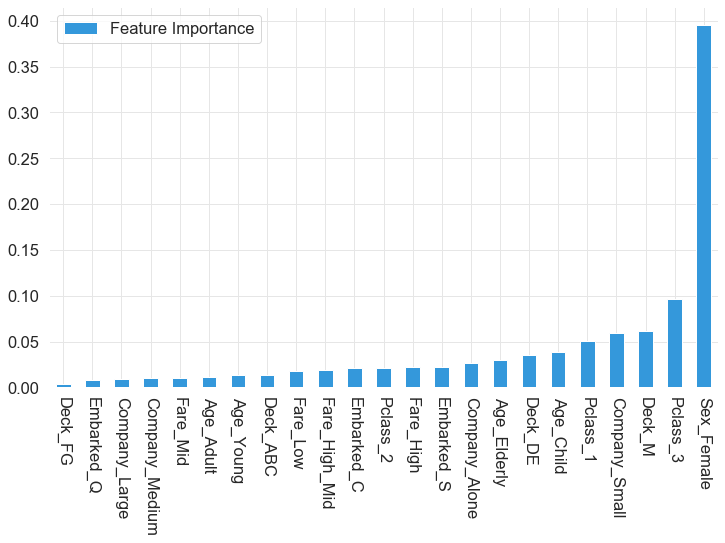

In [75]:
feats = {}
for feature, importance in zip(x_train.columns, best_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Feature Importance'})
importances.sort_values(by='Feature Importance').plot(kind='bar', rot=-90)

## Сохраним полученные данные

In [76]:
X_to_be_predicted = X_to_predict.drop('PassengerId', axis=1)
result = best_clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId': X_to_predict.PassengerId, 'Survived': result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'answer/answers.csv'
submission.to_csv(filename, index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: answer/answers.csv


## И попадем в топ 50%!

<img src="files/images/victory.png">

# Вывод

#### На самом деле, можно было больше поработать на этапе предварительной обработки данных, так как, по моему мнению, это решающий этап в решении данной задачи. Изучив несколько ноутбуков мастеров, я был удивлен, на какие хитрости они идут: используют дополнительную модель для подсчета количества выживших родственников/друзей, вычленяют титулы из имени, находят родственников в датасете. В процессе решения этой задачи я немного прокачал свои навыки фича-инжиниринга. Машинное обучение очень поощряет нестандартно мыслящих людей, готовых придумывать ловкие трюки для увеличения точности модели, а задачка с "Титаником" является отличным началом для всех начинающих энтузиастов!